In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

classes = ('g','r','n')

C:\Users\Anton\AppData\Local\Temp\ipykernel_24664\1830881350.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


device is cpu


In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# image: input size 160x120
# out: one-hot [Green, Red, None]
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.ReLU()
        self.sig = nn.Softmax()
        
        # input: 160x120x3
        self.conv11 = nn.Conv2d(3, 9, kernel_size=7, padding=0) # output: 154x114x6
        self.conv12 = nn.Conv2d(9, 16, kernel_size=7, padding=0) # output: 148x108x6
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)      # output: 74x54x6

        self.conv21 = nn.Conv2d(16, 16, kernel_size=7, padding=0) # output: 68x48x3
        self.conv22 = nn.Conv2d(16, 16, kernel_size=7, padding=0) # output: 62x42x1
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)      # output: 31x21x1

        self.fc1 = nn.Linear(16*31*21,1000)
        self.fc2 = nn.Linear(1000,100)
        self.fc3 = nn.Linear(100,10)
        self.fc4 = nn.Linear(10,3)

        self.drop = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = self.conv11(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv12(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.pool1(x)

        x = self.conv21(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv22(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.pool2(x)

        x = torch.flatten(x,start_dim=1)

        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc4(x)

        return x

In [4]:
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None):
        self.image_dir = os.path.join(dir,"Images2")
        self.df = pd.read_csv(os.path.join(dir,"labels2.txt"))
        self.transform = transform

    def __getitem__(self,i,transform=None):              
        label = self.df["label"][i]
        if label=="g":
            label = torch.tensor([1,0,0])
        if label=="r":
            label = torch.tensor([0,1,0])
        if label=="n":
            label = torch.tensor([0,0,1])
        image_path = os.path.join(self.image_dir,self.df["image"][i])
        image = transforms.ToTensor()(Image.open(image_path))
        if self.transform!=None:
            image = self.transform(image)
        return (image,label)

    def __len__(self):
        return len(self.df)

In [5]:
transform = transforms.Compose([
    transforms.Resize((120,160)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augment = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
])

In [6]:
ds = CaptionDataset("data", transform=transform)

train_size = int(0.7 * len(ds))
val_size = int(0.15 * len(ds))
test_size = len(ds) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(ds, [train_size, val_size, test_size])

train_loader = DataLoader(train_set,batch_size=15,shuffle=True)
val_loader = DataLoader(val_set,batch_size=15,shuffle=True)
test_loader = DataLoader(test_set,batch_size=15,shuffle=True)
it = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 0, 1])


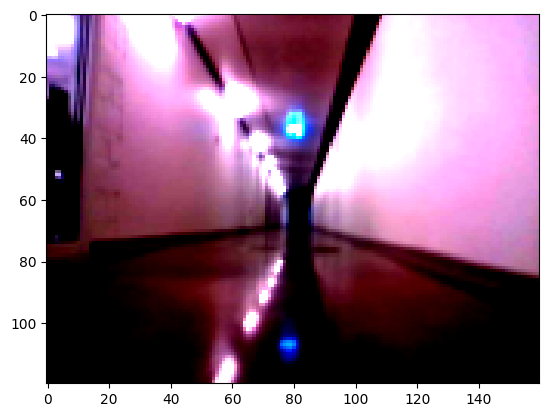

In [7]:
(images,labels) = next(it)
plt.imshow(images[0].permute(1, 2, 0))
print(labels[0])

In [10]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, scheduler):
    best_val_loss = float('inf')
    best_model = model

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1} of {num_epochs}")
        model.train()
        train_loss = 0.0
        for batch_nr, (inputs, labels) in enumerate(train_loader):
            if (batch_nr%7 == 0):
                print(f"Processing batch number {batch_nr+1} of {len(train_loader)}")
            inputs = augment(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device).to(torch.float)
            optimizer.zero_grad()
            outputs = model(inputs).to(torch.float)
            #print(nn.Softmax()(outputs))
            #print(labels)
            loss = criterion(outputs, labels)
            loss = loss.to(device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        scheduler.step()
    
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).to(torch.float)
                outputs = model(inputs).to(torch.float)
            
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            torch.save(best_model, "CNN_model3.pt")
    return best_model

def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to(torch.float)
            labels = labels.to(torch.float)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = torch.argmax(outputs,dim=1)
            total += labels.size(0)
            labels = torch.argmax(labels,dim=1)
            for image, pred, label, output in zip(inputs, predicted, labels, outputs):
                if pred!=label or pred==1:
                    print("label:",label.item())
                    print("prediction:",pred.item())
                    print("output:",nn.Softmax()(output).tolist())
                    plt.imshow(image.permute(1,2,0))
                    plt.show()
            print(predicted)
            print(labels)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_targets, all_predictions)

    return test_loss, accuracy, conf_matrix

cpu


C:\Users\Anton\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.006963604129850864, 0.9905710220336914, 0.0024654169101268053]


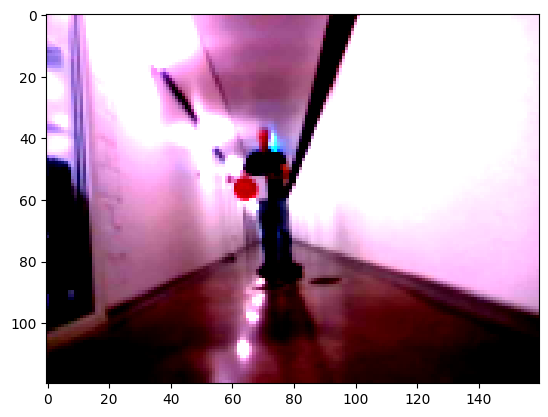

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.3217531957820938e-08, 1.0, 6.046771416912122e-11]


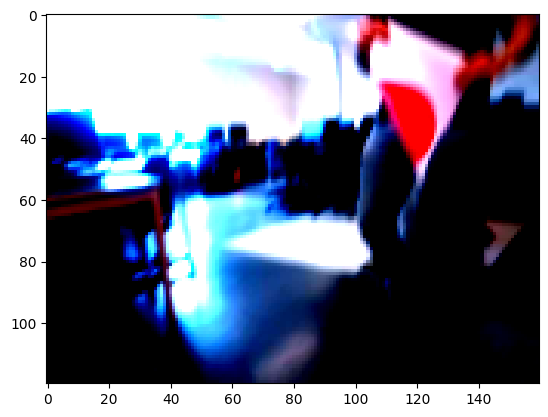

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.2455638462912505e-13, 1.0, 9.897295438535781e-18]


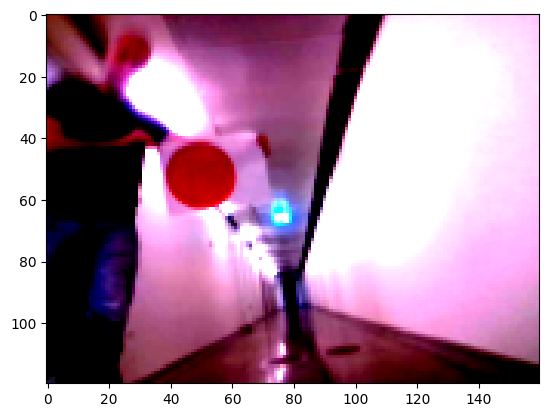

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 0
prediction: 2
output: [0.05042977258563042, 0.024158990010619164, 0.9254112839698792]


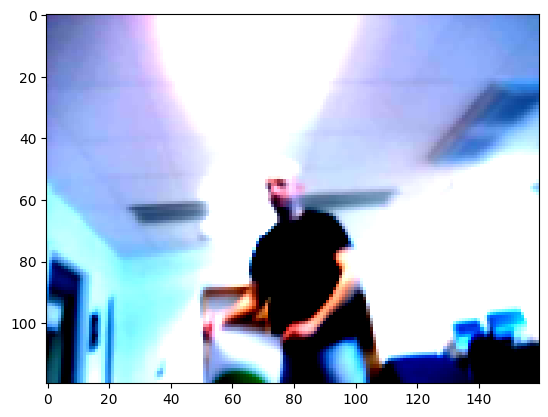

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [3.664369074840579e-08, 1.0, 2.115931596602394e-10]


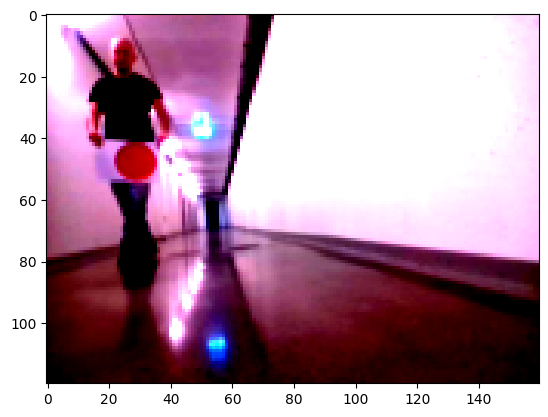

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.0004350053786765784, 0.9995039701461792, 6.096550350775942e-05]


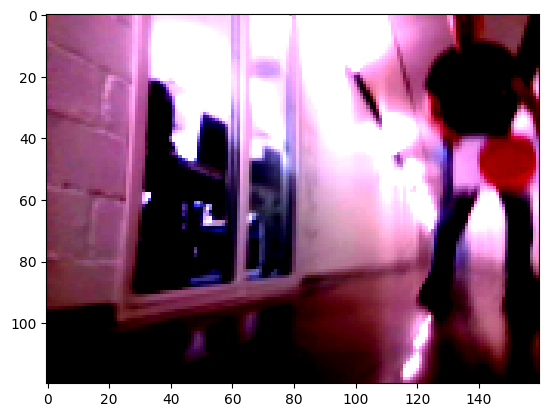

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [3.640215299333116e-13, 1.0, 3.881816339646e-17]


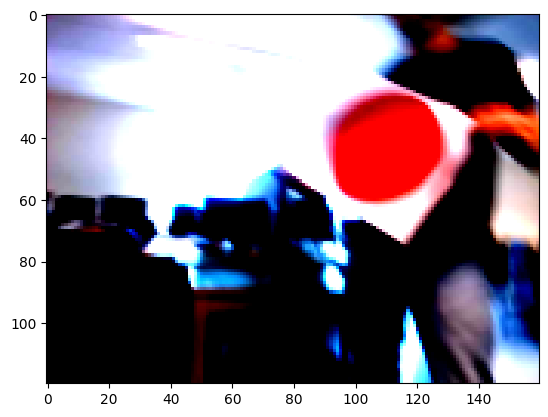

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [3.951532789268084e-15, 1.0, 1.0421444973576725e-19]


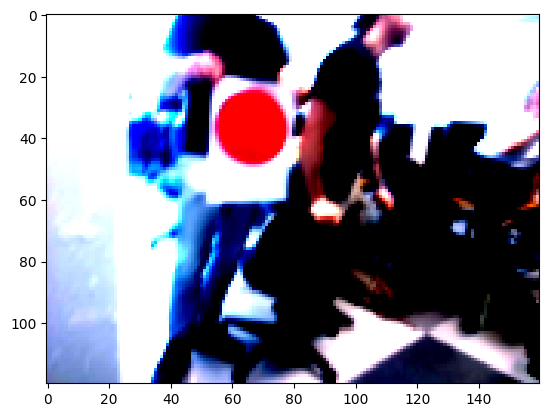

tensor([0, 0, 0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 0])
tensor([0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.0035874454770237207, 0.9953505992889404, 0.0010620029643177986]


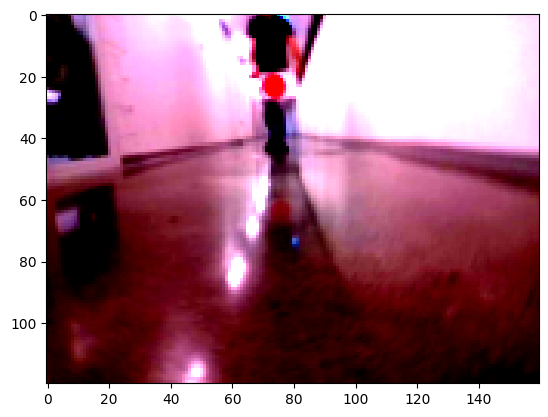

label: 1
prediction: 1
output: [0.04229273274540901, 0.9297853708267212, 0.027921903878450394]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


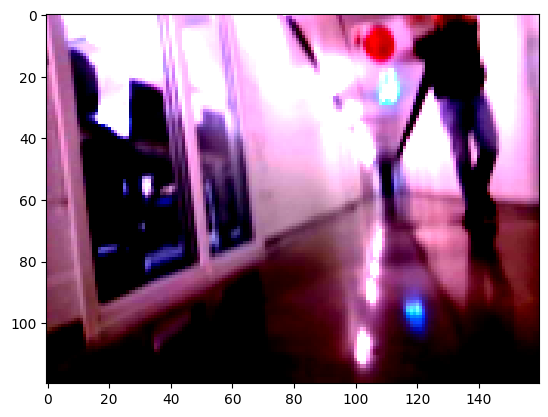

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [4.387014485018881e-08, 1.0, 2.5364363387403444e-10]


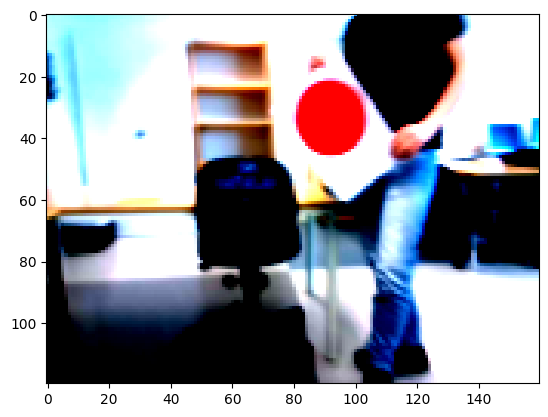

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [4.502840238274075e-05, 0.9999520778656006, 2.867554940166883e-06]


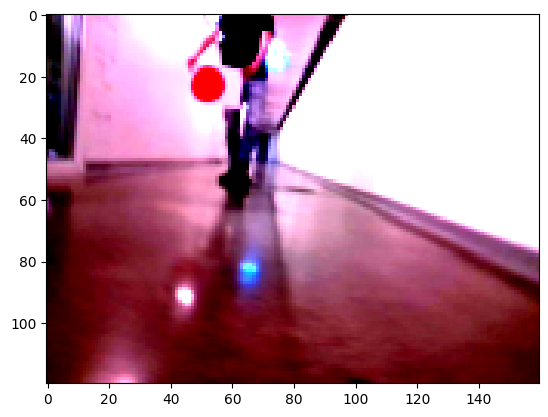

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.4938918730928817e-33, 1.0, 1.961817850054744e-44]


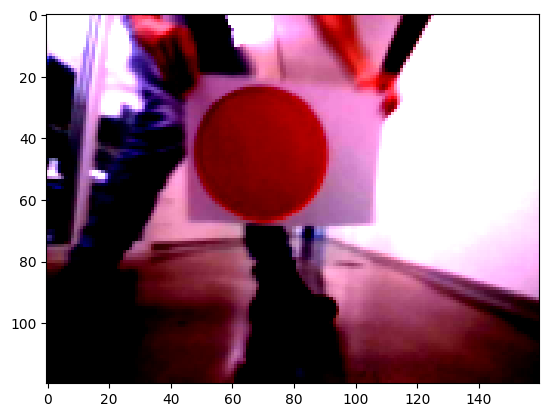

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.4978523976694191e-10, 1.0, 1.3237581332741638e-13]


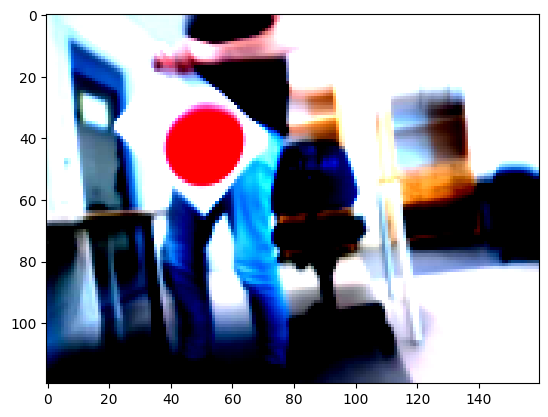

tensor([1, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 2, 1, 2, 2])
tensor([1, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 2, 1, 2, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [5.878729315679179e-20, 1.0, 3.329676802200125e-26]


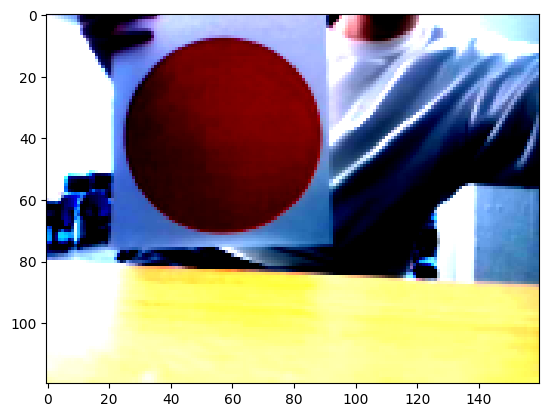

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [4.6369914066249004e-14, 1.0, 2.5365371474798242e-18]


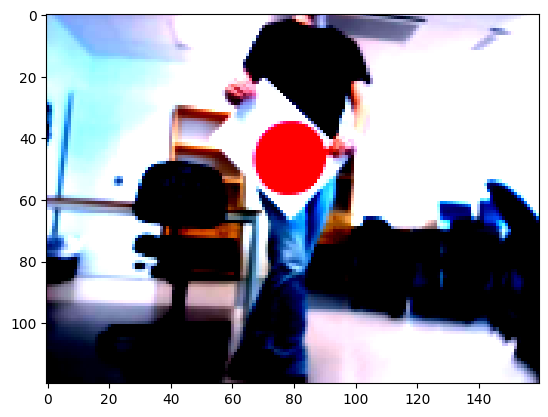

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [2.8124816253694007e-07, 0.9999997615814209, 3.3974114632684405e-09]


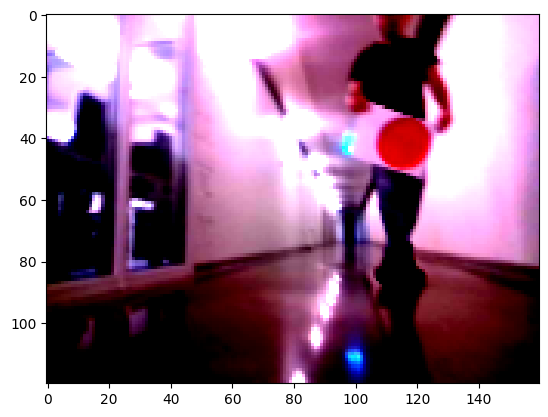

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [5.336577846293267e-09, 1.0, 1.57450580351437e-11]


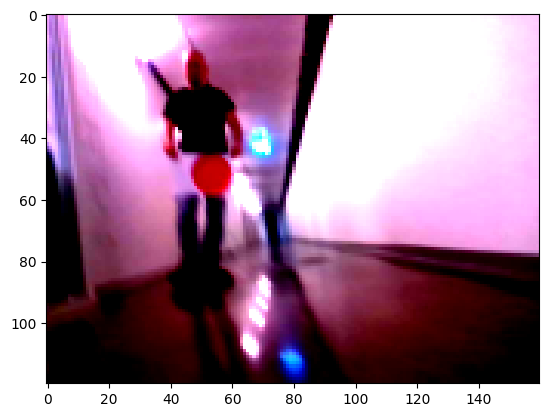

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.6124142344990013e-17, 1.0, 5.761366104102413e-23]


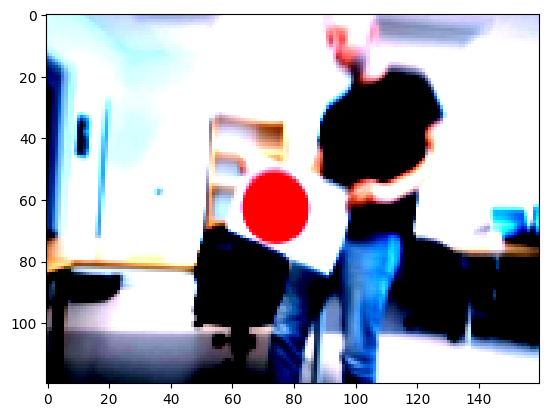

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.968858123291284e-05, 0.9999793767929077, 9.384954182678484e-07]


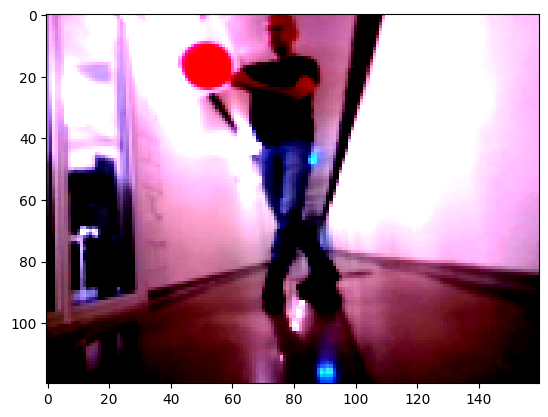

tensor([1, 0, 1, 0, 0, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1])
tensor([1, 0, 1, 0, 0, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [2.5756997956705163e-07, 0.9999997615814209, 2.9299811465932635e-09]


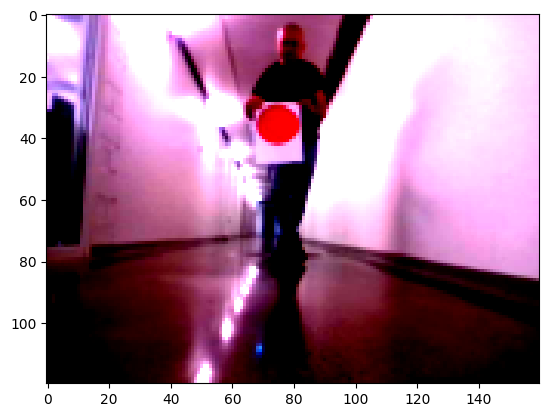

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.0003749201714526862, 0.9995760321617126, 4.9112877604784444e-05]


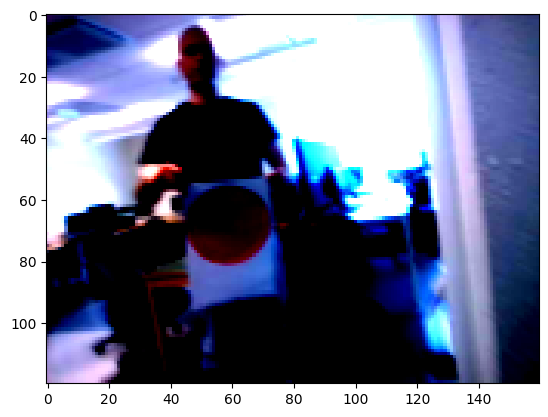

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [2.0061916111128162e-25, 1.0, 1.3226063668017429e-33]


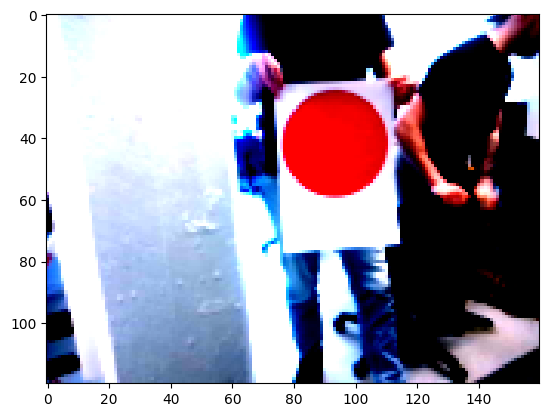

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [7.195047510322183e-05, 0.9999228715896606, 5.107916877022944e-06]


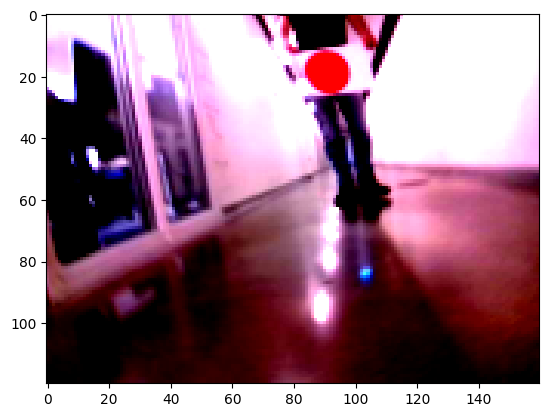

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.04743654653429985, 0.9198722839355469, 0.032691117376089096]


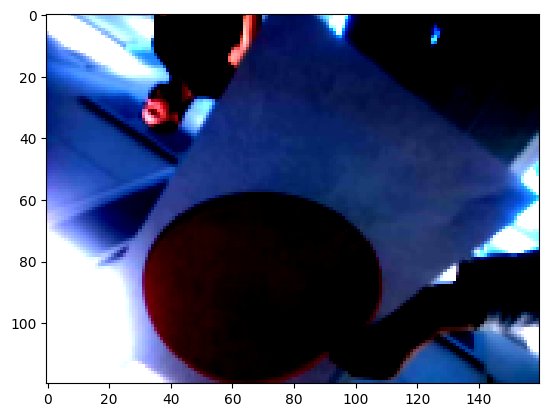

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.1237016224185936e-06, 0.999998927116394, 2.0863158312067753e-08]


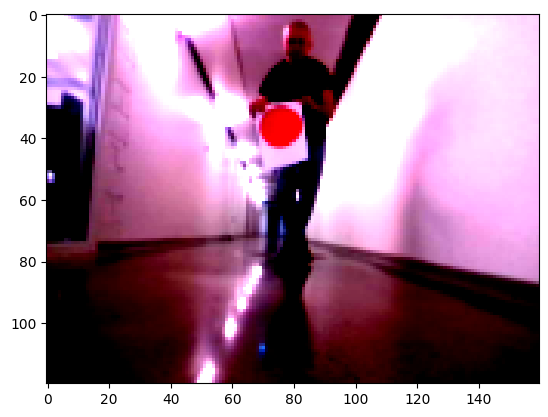

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [4.385778351699622e-22, 1.0, 4.757341870659207e-29]


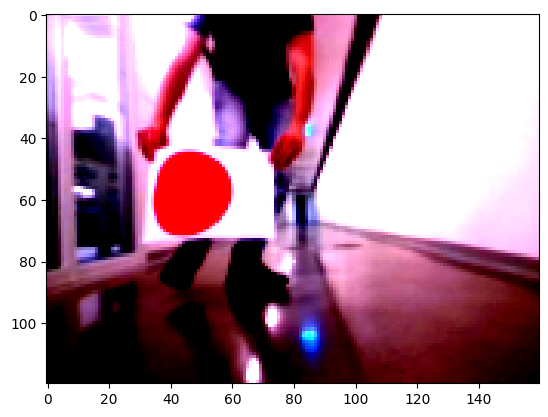

tensor([0, 1, 0, 0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0])
tensor([0, 1, 0, 0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [6.507446554915818e-16, 1.0, 8.341915336999114e-21]


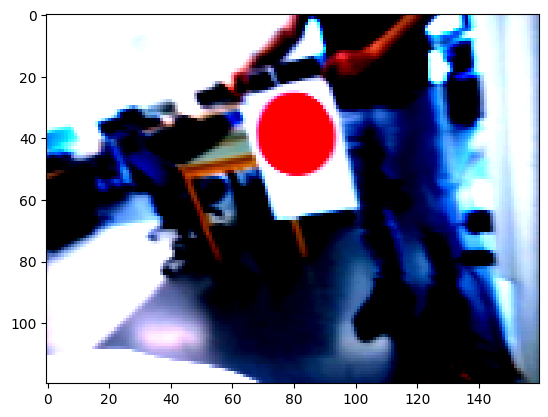

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.512538466870439e-12, 1.0, 2.549412734837998e-16]


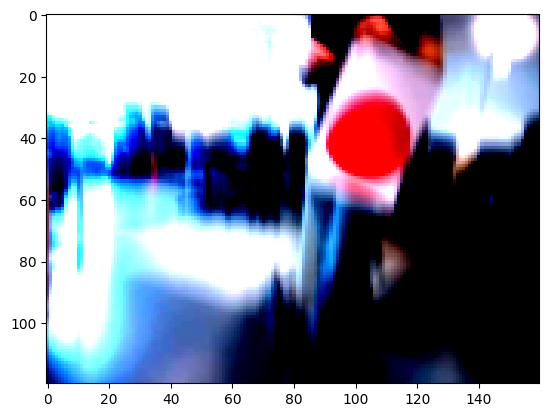

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [8.36538475041212e-25, 1.0, 1.0761870452284852e-32]


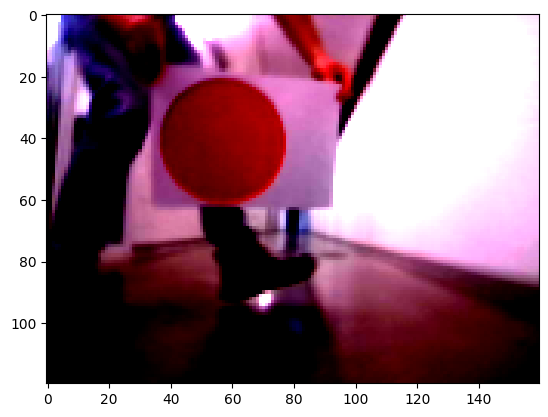

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.006798433139920235, 0.9907258749008179, 0.002475664485245943]


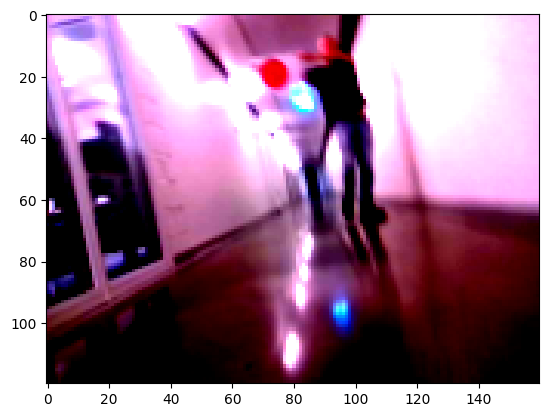

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.034424036741256714, 0.943832516670227, 0.0217435359954834]


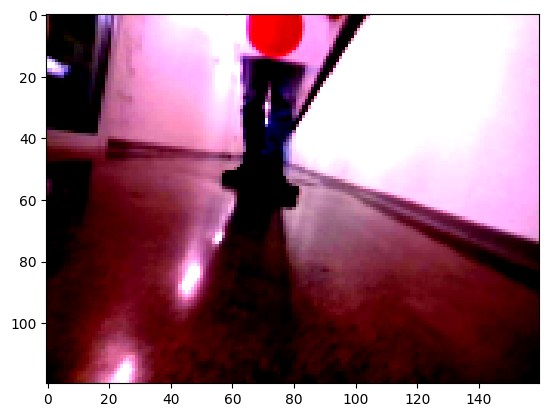

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [5.756735959039361e-07, 0.9999994039535522, 8.527805128721866e-09]


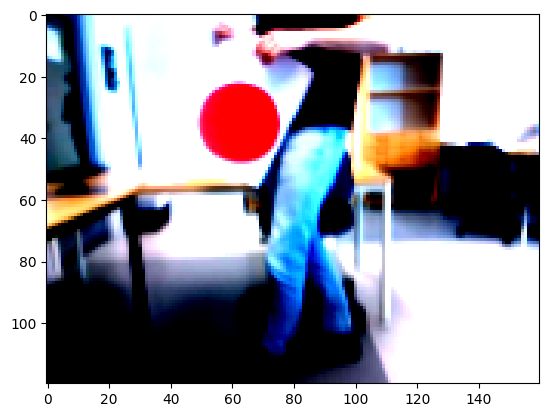

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.7456604521794799e-22, 1.0, 1.1900468580380097e-29]


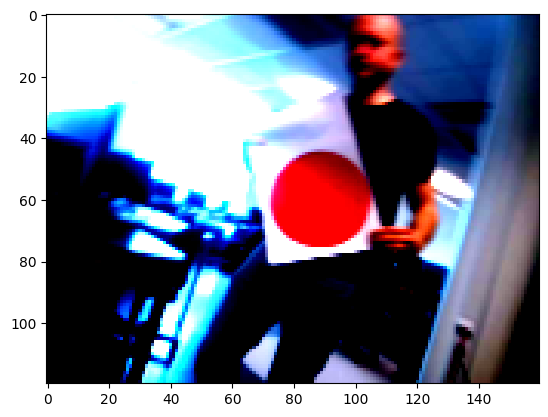

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [3.8807844248367473e-05, 0.999958872795105, 2.317573034815723e-06]


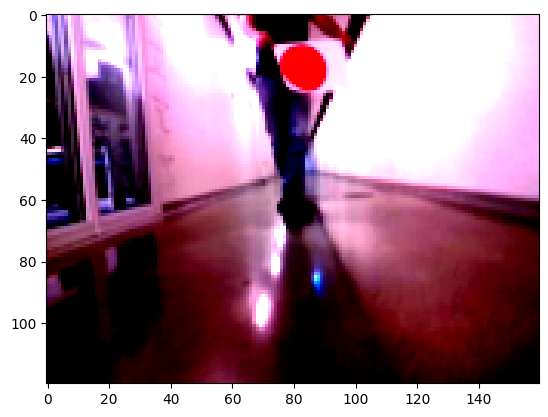

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.0015535365091636777, 0.9981058835983276, 0.0003405865281820297]


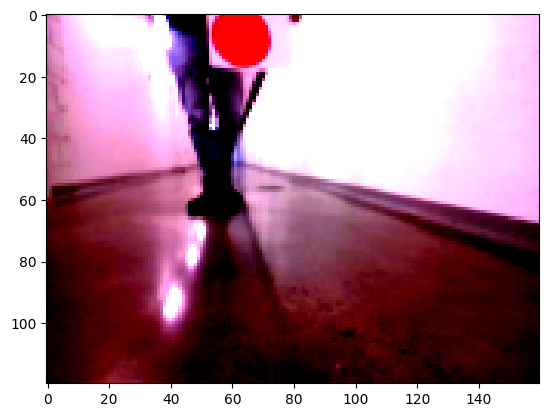

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [7.6798177851588125e-25, 1.0, 9.510078436570536e-33]


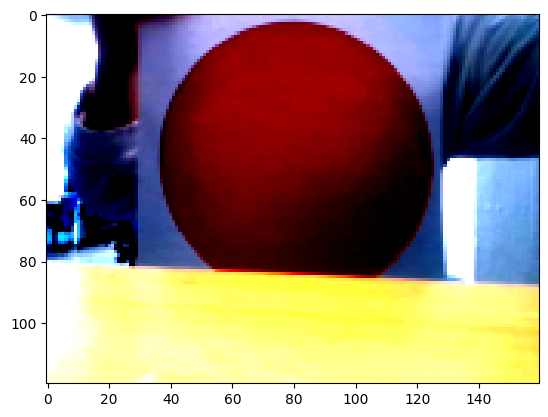

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [3.0129159167557873e-09, 1.0, 6.907035273590045e-12]


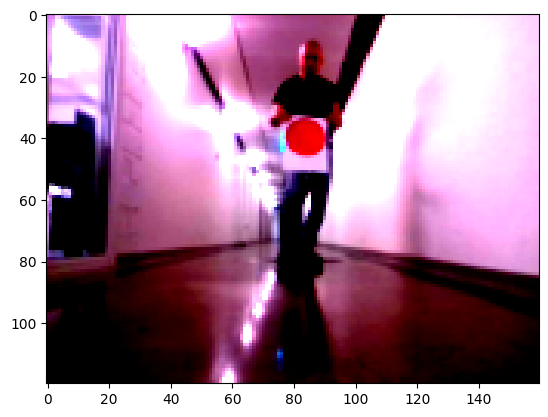

tensor([0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.007426707539707422, 0.989847719669342, 0.0027255204040557146]


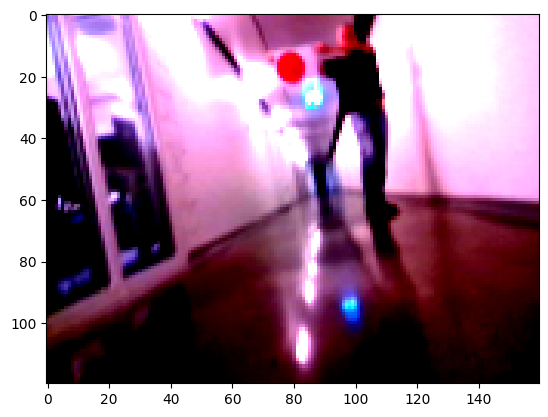

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [8.401355470952816e-34, 1.0, 8.407790785948902e-45]


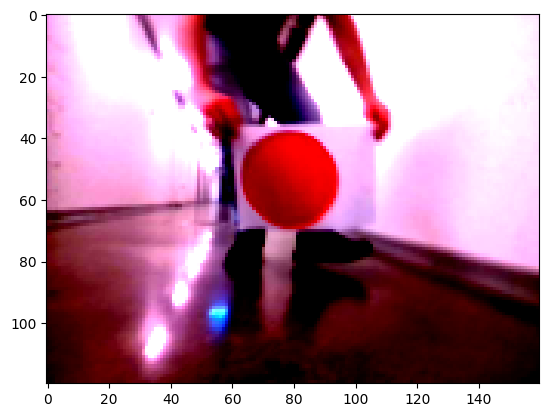

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.0023503375705331564, 0.9970718622207642, 0.000577795784920454]


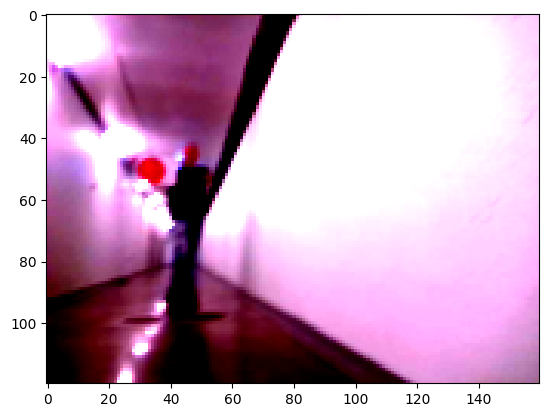

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.0009547668742015958, 0.9988753199577332, 0.0001699124404694885]


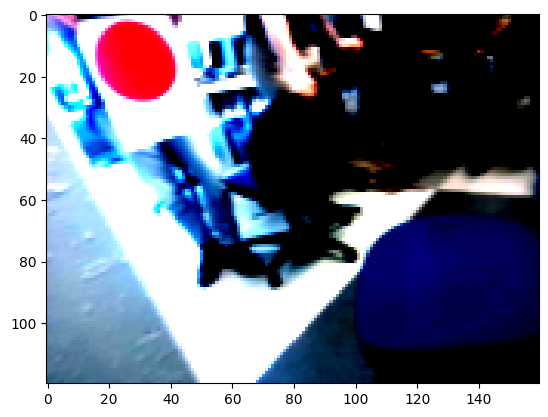

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.2838150825684898e-22, 1.0, 7.715181317667201e-30]


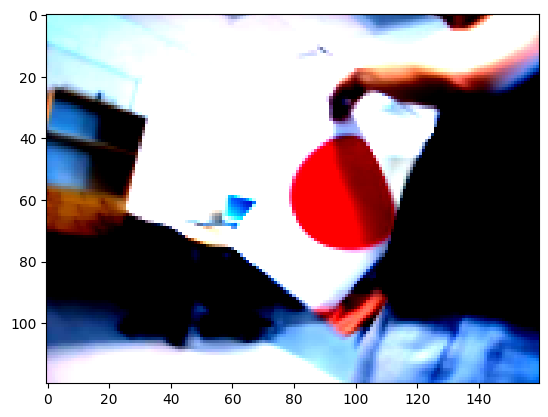

tensor([2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 1, 0, 1, 2])
tensor([2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 1, 0, 1, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.3744661210702326e-38, 1.0, 0.0]


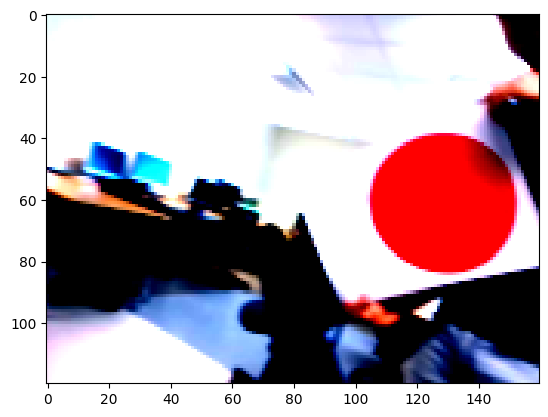

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.1691700965166092, 0.621848464012146, 0.20898140966892242]


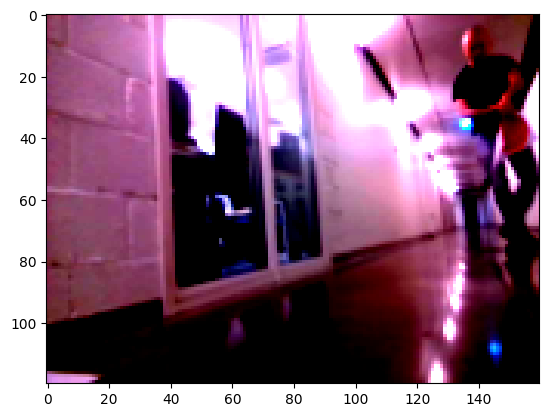

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.487606912653483e-12, 1.0, 2.575668903318309e-16]


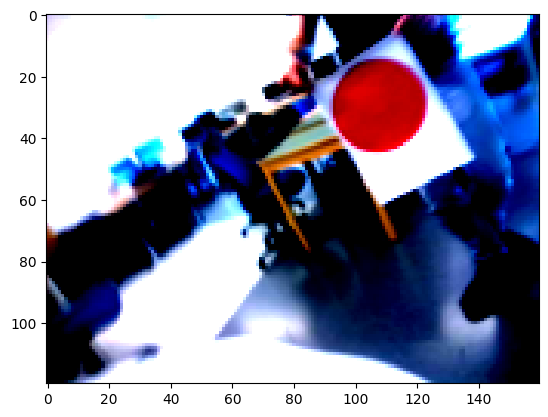

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.5106148554266952e-09, 1.0, 2.984564852204219e-12]


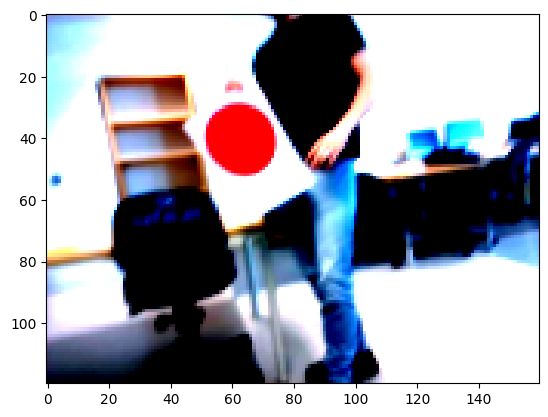

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [5.635135413850634e-11, 1.0, 3.454962010929208e-14]


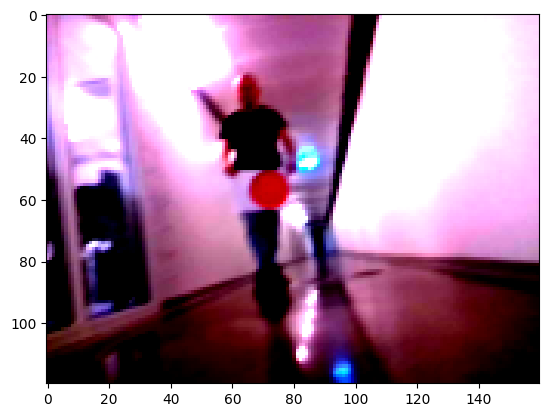

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [7.358354897624153e-11, 1.0, 5.088447092610644e-14]


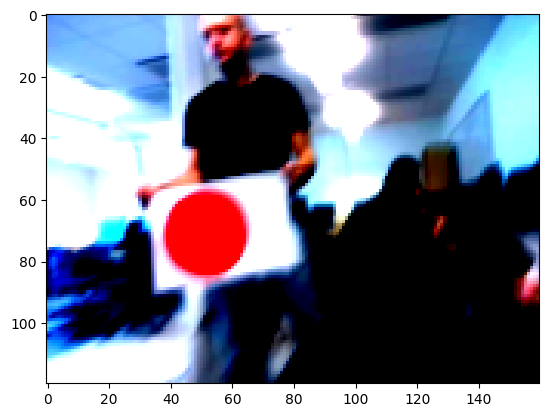

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [9.154826331215084e-26, 1.0, 5.561987896627448e-34]


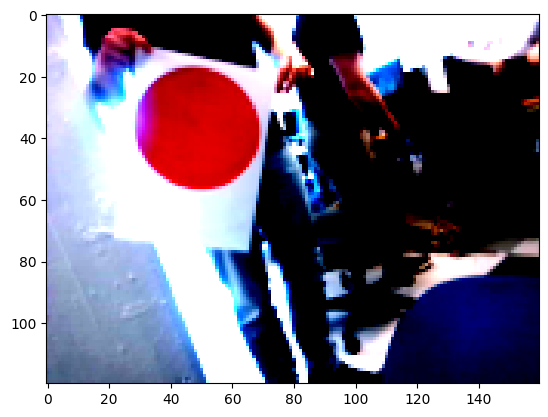

tensor([0, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.0033280188217759132, 0.9957693815231323, 0.0009026331827044487]


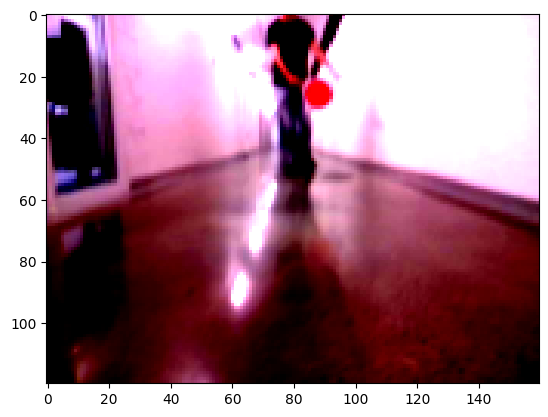

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.7407277061100983e-28, 1.0, 1.044957345261065e-37]


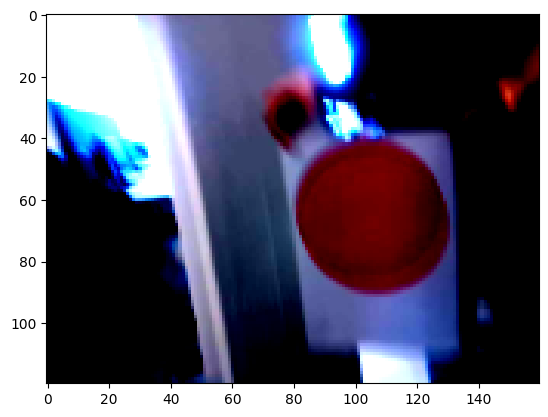

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.7194069779069565e-10, 1.0, 1.5016948188423251e-13]


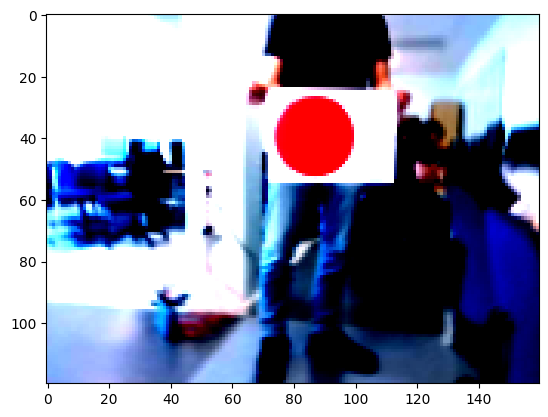

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [2.605954421142087e-07, 0.9999997615814209, 2.843363322568848e-09]


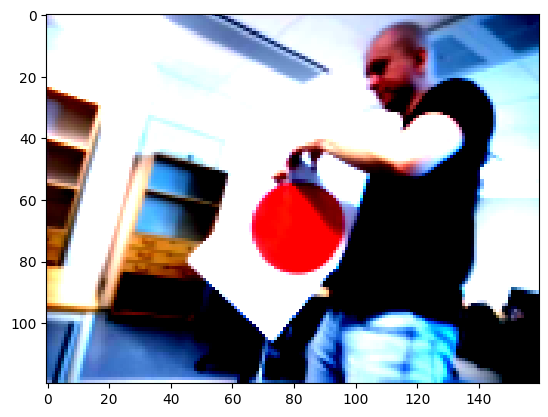

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.3796088604266291e-23, 1.0, 3.8258078776749377e-31]


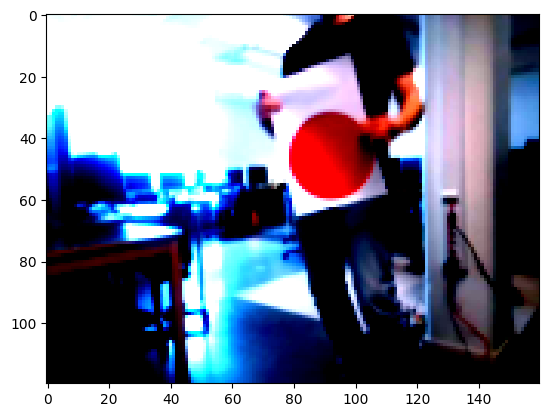

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.03906397521495819, 0.9354981184005737, 0.02543795108795166]


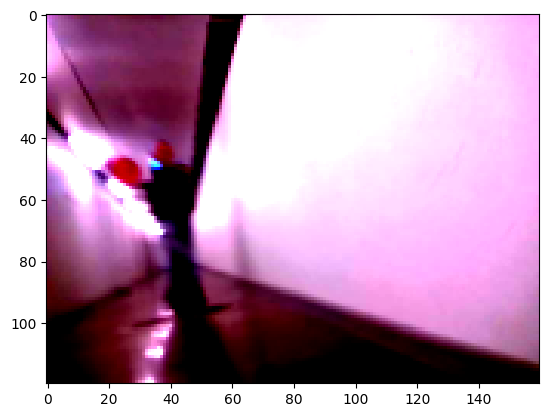

tensor([0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 0])
tensor([0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [3.9628470403840765e-05, 0.999957799911499, 2.5693811949167866e-06]


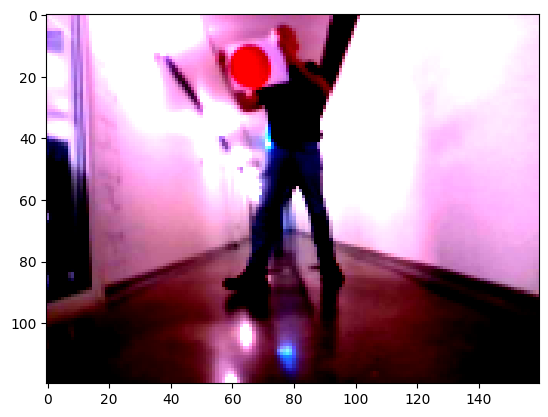

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.0488567449111136e-19, 1.0, 6.286687700905275e-26]


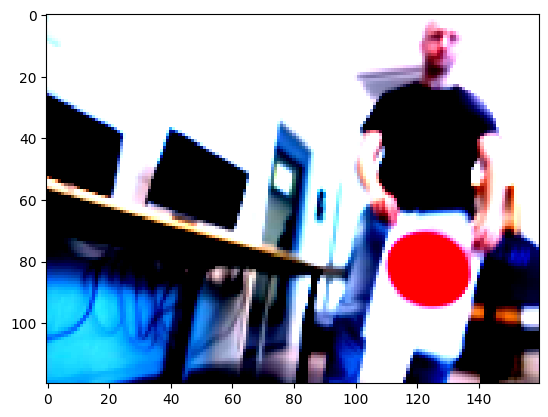

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.3505654927747912e-12, 1.0, 2.4234412008289504e-16]


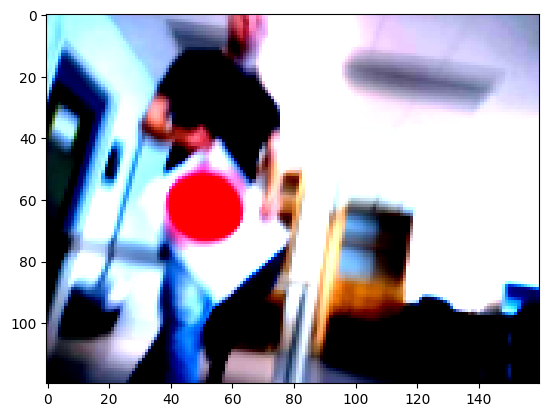

tensor([2, 0, 2, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2])
tensor([2, 0, 2, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.2858537180515596e-15, 1.0, 2.1897430521472054e-20]


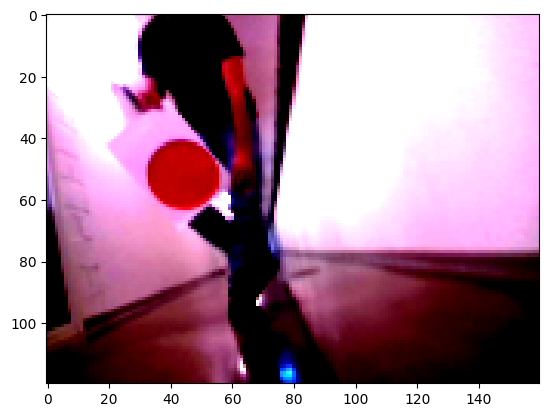

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [2.4545477117499104e-07, 0.9999997615814209, 2.5138053860729315e-09]


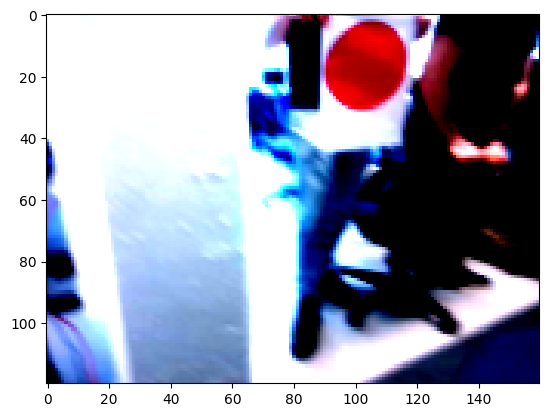

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [2.1847302473381706e-26, 1.0, 6.667269648450884e-35]


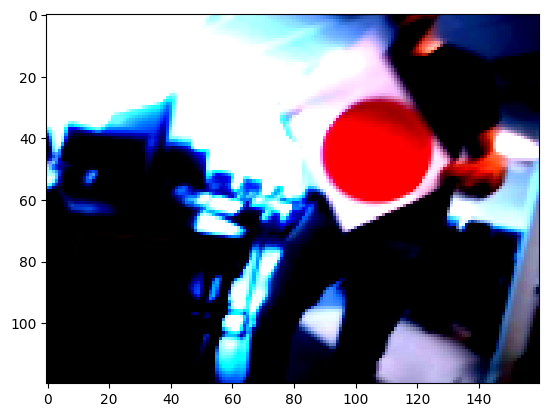

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.4033871416037954e-14, 1.0, 6.429660425713964e-19]


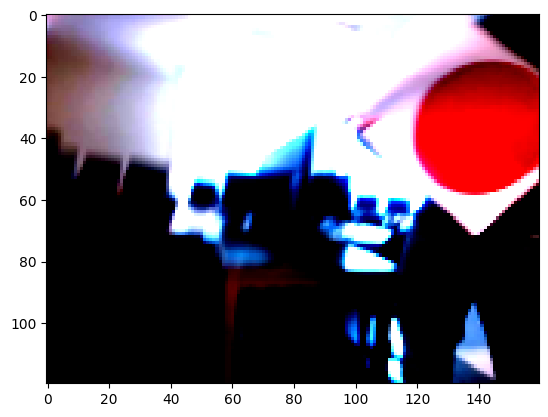

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [8.592337690060958e-05, 0.9999067783355713, 7.261773589561926e-06]


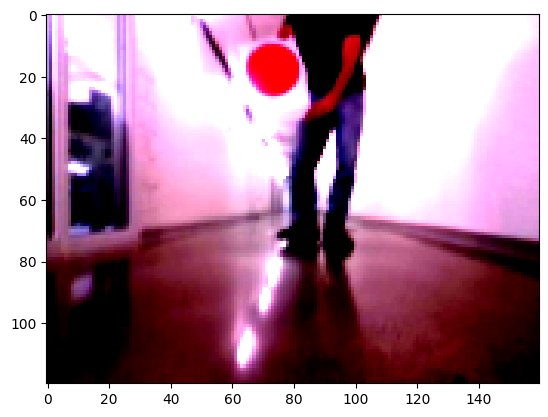

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [3.2754758884289094e-21, 1.0, 6.2635098466186545e-28]


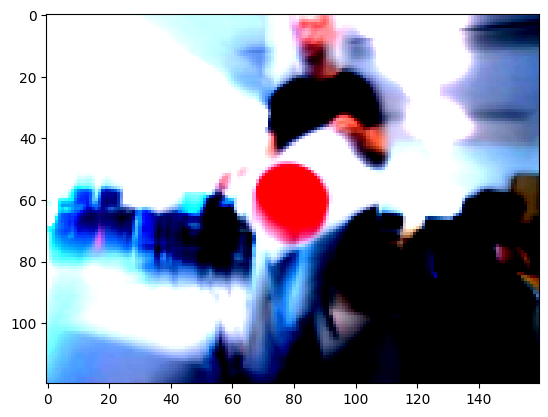

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [4.825505967032129e-11, 1.0, 2.845673593683887e-14]


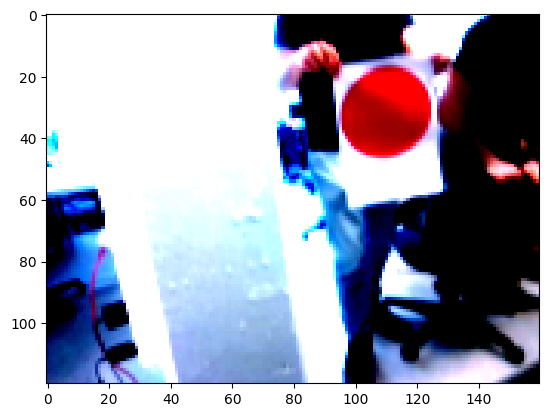

tensor([1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 0, 2, 1])
tensor([1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 0, 2, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [5.395079782227752e-12, 1.0, 1.517969650598563e-15]


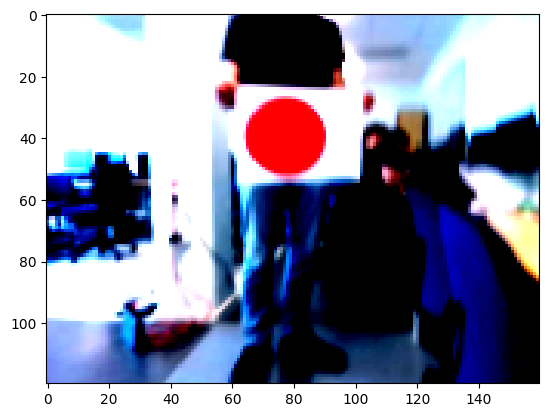

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.2651425046472653e-13, 1.0, 1.0082381236497584e-17]


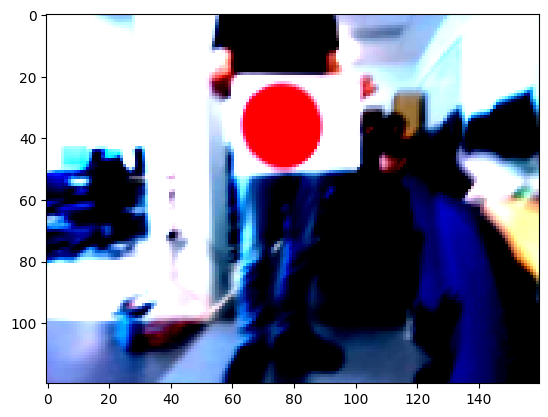

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.915450251537537e-36, 1.0, 0.0]


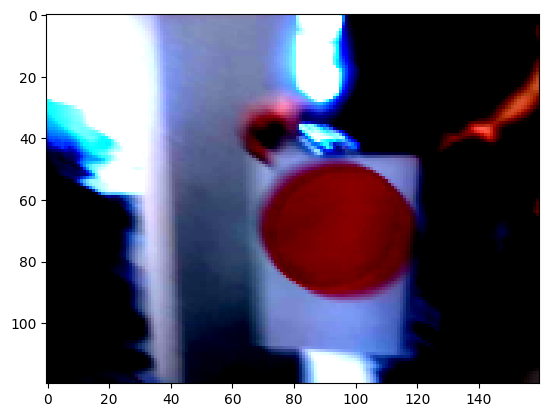

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.013404009863734245, 0.9807196259498596, 0.005876300856471062]


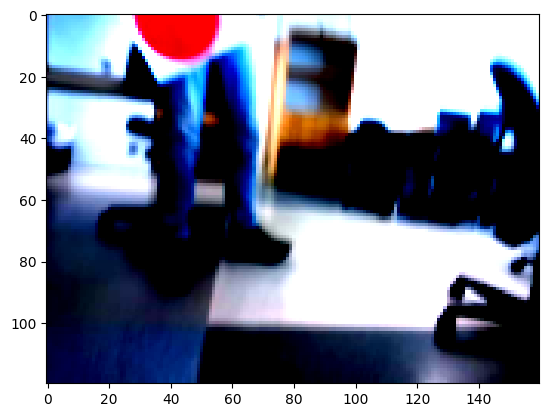

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [4.4755990580291893e-11, 1.0, 2.476725015397932e-14]


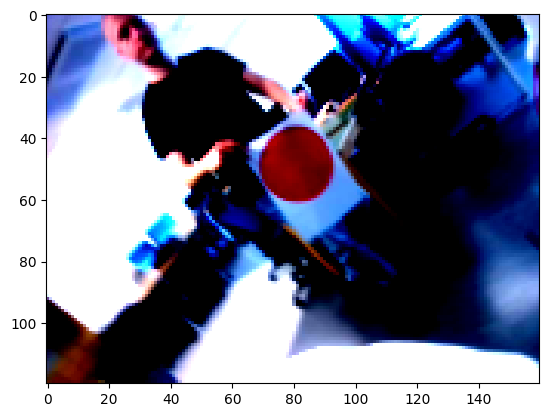

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [7.127358458092203e-06, 0.9999926090240479, 2.600982327294332e-07]


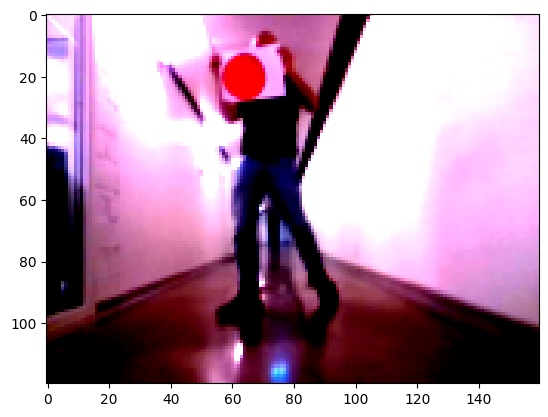

tensor([0, 2, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1])
tensor([0, 2, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [2.839827331624356e-11, 1.0, 1.445975873488447e-14]


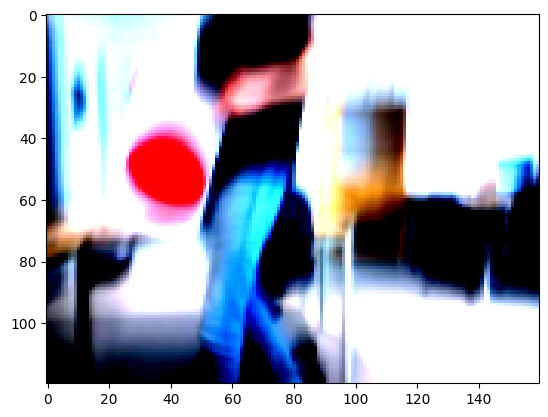

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [6.533265177939313e-16, 1.0, 8.074412073924141e-21]


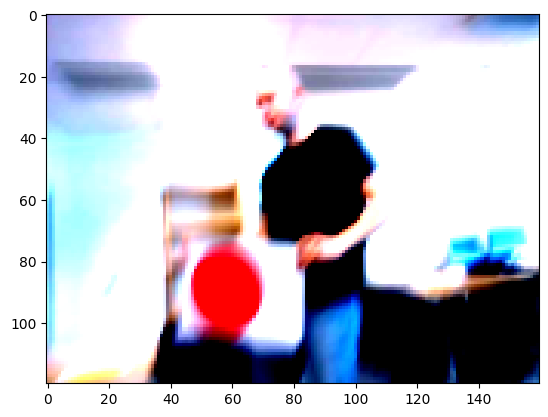

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.0003572616842575371, 0.9995959401130676, 4.680353595176712e-05]


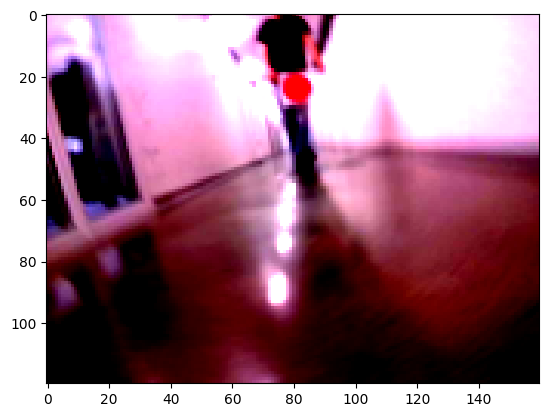

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [4.330711345090776e-09, 1.0, 1.2318007724942959e-11]


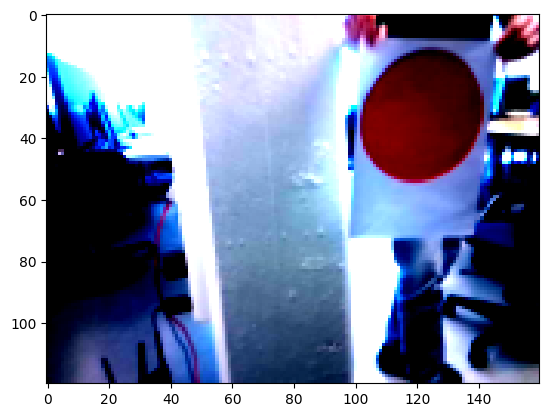

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [5.321744906510849e-25, 1.0, 4.8408469998174334e-33]


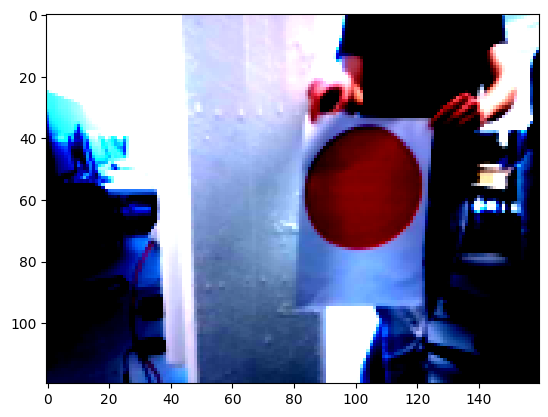

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [1.915436993044084e-12, 1.0, 3.5757575277679094e-16]


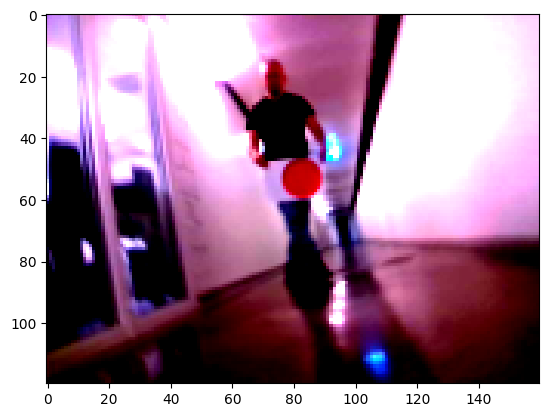

tensor([2, 0, 1, 1, 1, 0, 1, 2, 1, 2, 0, 1, 2, 2, 2])
tensor([2, 0, 1, 1, 1, 0, 1, 2, 1, 2, 0, 1, 2, 2, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [0.014092794619500637, 0.9795445799827576, 0.006362615153193474]


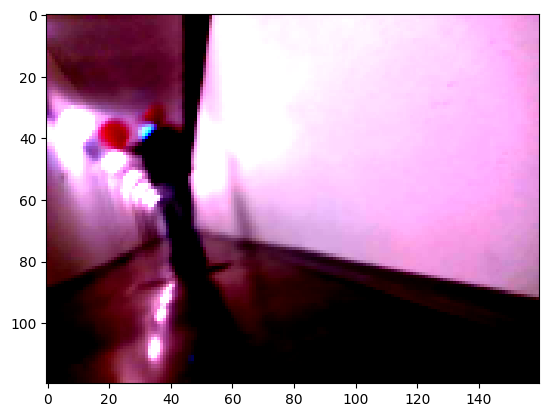

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1
prediction: 1
output: [2.0629019380649409e-22, 1.0, 1.7696777433663304e-29]


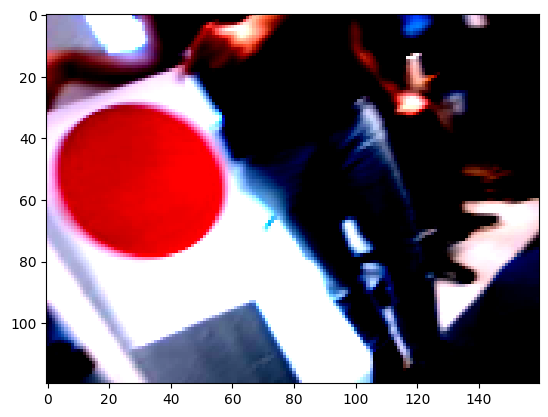

tensor([2, 0, 1, 1, 0, 2])
tensor([2, 0, 1, 1, 0, 2])
Test Loss: 0.0031, Test Accuracy: 99.46%
Confusion matrix, without normalization


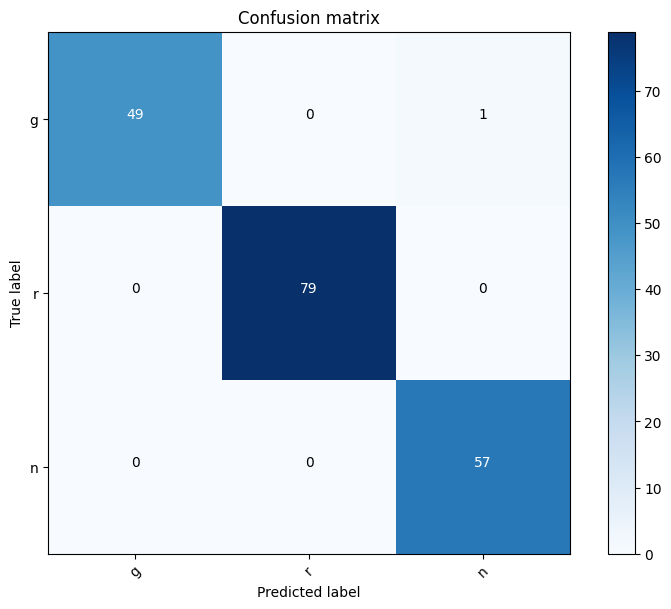

In [11]:
LEARNING_RATE = 0.001
EPOCHS = 100

print(device)
#model = CNN().to(device)
model = torch.load("CNN_model3.pt")
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0906515,1.02122,1])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

# Train the model
#trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS, scheduler)
#trained_model = torch.load("CNN_model.pt")
# Test the model
test_loss, test_accuracy, conf_matrix = test_model(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=classes, normalize=False)
plt.show()

In [107]:
image, label = next(it)

In [108]:
from time import perf_counter

In [228]:
model = torch.jit.load('model_scripted2.pt')
print(label[0])
print(image.shape)
img = torch.unsqueeze(image[0],dim=0)
pred=0
t1_start = perf_counter() 
pred = torch.argmax(model(img))
t1_stop = perf_counter() 
print(pred)
print(t1_stop-t1_start)

tensor([0, 0, 1])
torch.Size([15, 3, 120, 160])
tensor(2)
0.03344250000009197


In [229]:
# Saving model
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted2.pt') # Save

# Loading model
model = torch.jit.load('model_scripted2.pt')
model.eval()

RecursiveScriptModule(
  original_name=CNN
  (act): RecursiveScriptModule(original_name=ReLU)
  (sig): RecursiveScriptModule(original_name=Softmax)
  (conv11): RecursiveScriptModule(original_name=Conv2d)
  (conv12): RecursiveScriptModule(original_name=Conv2d)
  (pool1): RecursiveScriptModule(original_name=MaxPool2d)
  (conv21): RecursiveScriptModule(original_name=Conv2d)
  (conv22): RecursiveScriptModule(original_name=Conv2d)
  (pool2): RecursiveScriptModule(original_name=MaxPool2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (fc4): RecursiveScriptModule(original_name=Linear)
  (drop): RecursiveScriptModule(original_name=Dropout)
)